In [102]:
from IPython.core.interactiveshell import InteractiveShell

# Set shell to show all lines of output
InteractiveShell.ast_node_interactivity = 'all'

In [103]:
import json

books = []

with open('./found_books_filtered.ndjson', 'r') as fin:
    # Append each line to the books
    books = [json.loads(l) for l in fin]

# Remove non-book articles
books_with_wikipedia = [book for book in books if 'Wikipedia:' in book[0]]
books = [book for book in books if 'Wikipedia:' not in book[0]]
books = books[:9999]
print(f'Found {len(books)} books.')
[book[0] for book in books_with_wikipedia][:5]

n = 10
books[n][0], books[n][1], books[n][2][:5], books[n][3][:5], books[n][3][:5], books[n][4], books[n][5]
book_index = {book[0]: idx for idx, book in enumerate(books)}
index_book = {idx: book for book, idx in book_index.items()}


from itertools import chain

wikilinks = list(chain(*[book[2] for book in books]))
print(f"There are {len(set(wikilinks))} unique wikilinks.")

wikilinks_other_books = [link for link in wikilinks if link in book_index.keys()]
print(f"There are {len(set(wikilinks_other_books))} unique wikilinks to other books.")

Found 9999 books.


['Wikipedia:Wikipedia Signpost/2014-06-25/Recent research',
 'Wikipedia:New pages patrol/Unpatrolled articles/December 2010',
 'Wikipedia:Templates for discussion/Log/2012 September 23',
 'Wikipedia:Articles for creation/Redirects/2012-10',
 'Wikipedia:Templates for discussion/Log/2012 October 4']

('The Heist (Silva novel)',
 {'name': 'The Heist',
  'author': 'Daniel Silva',
  'country': 'United States',
  'language': 'English',
  'series': 'Gabriel Allon series',
  'genre': 'Spy fiction  < br >  Thriller',
  'media_type': 'Print (Hardback and Paperback)',
  'preceded_by': 'The English Girl',
  'followed_by': 'The English Spy'},
 ['Daniel Silva (novelist)',
  'English language',
  'Gabriel Allon',
  'Spy fiction',
  'Thriller (genre)'],
 ['http://danielsilvabooks.com/2014/01/the-heist-coming-july-2014/',
  'https://www.nytimes.com/best-sellers-books/2014-08-03/hardcover-fiction/list.html',
  'http://www.harpercollins.com/books/The-Heist-Daniel-Silva/?isbn=9780062320094',
  'http://myedmondsnews.com/2014/05/edmonds-booktalk-may-means-time-warm-weather-reading/',
  'http://danielsilvabooks.com/books/the-heist'],
 ['http://danielsilvabooks.com/2014/01/the-heist-coming-july-2014/',
  'https://www.nytimes.com/best-sellers-books/2014-08-03/hardcover-fiction/list.html',
  'http://www.h

There are 132106 unique wikilinks.
There are 3029 unique wikilinks to other books.


In [104]:
wikilinks[0]

'Sigmund Freud'

In [105]:
from collections import Counter, OrderedDict

def count_items(l):
    """Return ordered dictionary of counts of objects in `l`"""
    
    # Create a counter object
    counts = Counter(l)
    
    # Sort by highest count first and place in ordered dictionary
    counts = sorted(counts.items(), key = lambda x: x[1], reverse = True)
    counts = OrderedDict(counts)
    
    return counts

# Find set of wikilinks for each book and convert to a flattened list
unique_wikilinks = list(chain(*[list(set(book[2])) for book in books]))

wikilink_counts = count_items(unique_wikilinks)
list(wikilink_counts.items())[:10]

[('Hardcover', 2097),
 ('Paperback', 1912),
 ('Wikipedia:WikiProject Books', 1626),
 ('Wikipedia:WikiProject Novels', 1626),
 ('English language', 995),
 ('The New York Times', 860),
 ('Science fiction', 820),
 ('United States', 783),
 ('science fiction', 726),
 ('Publishers Weekly', 544)]

In [106]:

# Limit to greater than 3 links
links = [t[0] for t in wikilink_counts.items() if t[1] >= 50]
print(len(links))


link_index = {link: idx for idx, link in enumerate(links)}
index_link = {idx: link for link, idx in link_index.items()}

pairs = []

# Iterate through each book
for book in books:
    # Iterate through the links in the book
    pairs.extend((book_index[book[0]], link_index[link]) for link in book[2] if link in links)
pairs_set = set(pairs)   
len(pairs), len(links), len(books)


357


(54592, 357, 9999)

In [107]:


import numpy as np
import random
random.seed(100)
def generate_batch(pairs, n_positive = 50, negative_ratio = 1.0, classification = False):
    """Generate batches of samples for training"""
    batch_size = n_positive * (1 + negative_ratio)
    batch = np.zeros((batch_size, 3))
    
    # Adjust label based on task
    if classification:
        neg_label = 0
    else:
        neg_label = -1
    
    # This creates a generator
    while True:
        # randomly choose positive examples
        for idx, (book_id, link_id) in enumerate(random.sample(pairs, n_positive)):
            batch[idx, :] = (book_id, link_id, 1)

        # Increment idx by 1
        idx += 1
        
        # Add negative examples until reach batch size
        while idx < batch_size:
            
            # random selection
            random_book = random.randrange(len(books))
            random_link = random.randrange(len(links))
            
            # Check to make sure this is not a positive example
            if (random_book, random_link) not in pairs_set:
                
                # Add to batch and increment index
                batch[idx, :] = (random_book, random_link, neg_label)
                idx += 1
                
        # Make sure to shuffle order, otherwise first half is going to be all positive
        np.random.shuffle(batch)
        yield {'book': batch[:, 0], 'link': batch[:, 1]}, batch[:, 2]
        

In [108]:
from keras.layers import Input, Embedding, Dot, Reshape, Dense
from keras.models import Model
def book_embedding_model(embedding_size = 50, classification = False):
    """Model to embed books and wikilinks using the functional API.
       Trained to discern if a link is present in a article"""
    
    # Both inputs are 1-dimensional
    book = Input(name = 'book', shape = [1])
    link = Input(name = 'link', shape = [1])
    
    # Embedding the book (shape will be (None, 1, 50))
    book_embedding = Embedding(name = 'book_embedding',
                               input_dim = len(book_index),
                               output_dim = embedding_size)(book)
    
    
    # Embedding the link (shape will be (None, 1, 50))
    link_embedding = Embedding(name = 'link_embedding',
                               input_dim = len(link_index),
                               output_dim = embedding_size)(link)
    
    # Merge the layers with a dot product along the second axis (shape will be (None, 1, 1))
    merged = Dot(name = 'dot_product', normalize = True, axes = 2)([book_embedding, link_embedding])
    
    # Reshape to be a single number (shape will be (None, 1))
    merged = Reshape(target_shape = [1])(merged)
    
    # If classifcation, add extra layer and loss function is binary cross entropy
    if classification:
        merged = Dense(1, activation = 'sigmoid')(merged)
        model = Model(inputs = [book, link], outputs = merged)
        model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    # Otherwise loss function is mean squared error
    else:
        model = Model(inputs = [book, link], outputs = merged)
        model.compile(optimizer = 'Adam', loss = 'mse')
    
    return model

# Instantiate model and show parameters
model = book_embedding_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
book (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
link (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
book_embedding (Embedding)      (None, 1, 50)        499950      book[0][0]                       
__________________________________________________________________________________________________
link_embedding (Embedding)      (None, 1, 50)        17850       link[0][0]                       
____________________________________________________________________________________________

In [109]:
n_positive = 1024

gen = generate_batch(pairs, n_positive, negative_ratio = 2)

# Train
h = model.fit(gen, epochs = 25, 
                        steps_per_epoch = len(pairs) // n_positive,
                        verbose = 2)

Epoch 1/25
53/53 - 2s - loss: 0.9945
Epoch 2/25
53/53 - 1s - loss: 0.9396
Epoch 3/25
53/53 - 1s - loss: 0.8644
Epoch 4/25
53/53 - 1s - loss: 0.7424
Epoch 5/25
53/53 - 1s - loss: 0.6268
Epoch 6/25
53/53 - 1s - loss: 0.5683
Epoch 7/25
53/53 - 1s - loss: 0.5379
Epoch 8/25
53/53 - 1s - loss: 0.5162
Epoch 9/25
53/53 - 1s - loss: 0.5022
Epoch 10/25
53/53 - 1s - loss: 0.4906
Epoch 11/25
53/53 - 1s - loss: 0.4841
Epoch 12/25
53/53 - 1s - loss: 0.4768
Epoch 13/25
53/53 - 1s - loss: 0.4702
Epoch 14/25
53/53 - 1s - loss: 0.4682
Epoch 15/25
53/53 - 1s - loss: 0.4666
Epoch 16/25
53/53 - 1s - loss: 0.4623
Epoch 17/25
53/53 - 1s - loss: 0.4604
Epoch 18/25
53/53 - 1s - loss: 0.4593
Epoch 19/25
53/53 - 1s - loss: 0.4598
Epoch 20/25
53/53 - 1s - loss: 0.4557
Epoch 21/25
53/53 - 1s - loss: 0.4573
Epoch 22/25
53/53 - 1s - loss: 0.4567
Epoch 23/25
53/53 - 1s - loss: 0.4558
Epoch 24/25
53/53 - 1s - loss: 0.4550
Epoch 25/25
53/53 - 1s - loss: 0.4571


In [110]:
model.save('./first_attempt.h5')# models can be saved so that you dont have to train every time

In [111]:
book_layer = model.get_layer('book_embedding')
book_weights = book_layer.get_weights()[0]
book_weights.shape
book_weights = book_weights / np.linalg.norm(book_weights, axis = 1).reshape((-1, 1))
book_weights[0][:10]
np.sum(np.square(book_weights[0]))

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 15

def extract_weights(name, model):
    """Extract weights from a neural network model"""
    
    # Extract weights
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    
    # Normalize
    weights = weights / np.linalg.norm(weights, axis = 1).reshape((-1, 1))
    return weights

def find_similar(name, weights, index_name = 'book', n = 10, least = False, return_dist = False, plot = False):
    """Find n most similar items (or least) to name based on embeddings. Option to also plot the results"""
    
    # Select index and reverse index
    if index_name == 'book':
        index = book_index
        rindex = index_book
    elif index_name == 'page':
        index = link_index
        rindex = index_link
     
    # Check to make sure `name` is in index
    try:
        # Calculate dot product between book and all others
        dists = np.dot(weights, weights[index[name]])
    except KeyError:
        print(f'{name} Not Found.')
        return
    
    # Sort distance indexes from smallest to largest
    sorted_dists = np.argsort(dists)
    
    # Plot results if specified
    if plot:
        
        # Find furthest and closest items
        furthest = sorted_dists[:(n // 2)]
        closest = sorted_dists[-n-1: len(dists) - 1]
        items = [rindex[c] for c in furthest]
        items.extend(rindex[c] for c in closest)
        
        # Find furthest and closets distances
        distances = [dists[c] for c in furthest]
        distances.extend(dists[c] for c in closest)
        
        colors = ['r' for _ in range(n //2)]
        colors.extend('g' for _ in range(n))
        
        data = pd.DataFrame({'distance': distances}, index = items)
        
        # Horizontal bar chart
        data['distance'].plot.barh(color = colors, figsize = (10, 8),
                                   edgecolor = 'k', linewidth = 2)
        plt.xlabel('Cosine Similarity');
        plt.axvline(x = 0, color = 'k');
        
        # Formatting for italicized title
        name_str = f'{index_name.capitalize()}s Most and Least Similar to'
        for word in name.split():
            # Title uses latex for italize
            name_str += ' $\it{' + word + '}$'
        plt.title(name_str, x = 0.2, size = 28, y = 1.05)
        
        return None
    
    # If specified, find the least similar
    if least:
        # Take the first n from sorted distances
        closest = sorted_dists[:n]
         
        print(f'{index_name.capitalize()}s furthest from {name}.\n')
        
    # Otherwise find the most similar
    else:
        # Take the last n sorted distances
        closest = sorted_dists[-n:]
        
        # Need distances later on
        if return_dist:
            return dists, closest
        
        
        print(f'{index_name.capitalize()}s closest to {name}.\n')
        
    # Need distances later on
    if return_dist:
        return dists, closest
    
    
    # Print formatting
    max_width = max([len(rindex[c]) for c in closest])
    
    # Print the most similar and distances
    for c in reversed(closest):
        print(f'{index_name.capitalize()}: {rindex[c]:{max_width + 2}} Similarity: {dists[c]:.{2}}')

(9999, 50)

array([ 0.07525425,  0.23589393, -0.28883576, -0.12833697, -0.16264485,
        0.05540678,  0.01203288, -0.09259518,  0.08461401, -0.13967162],
      dtype=float32)

1.0

In [112]:
print(book[0])
find_similar('The Railway Man (book)', book_weights)

The Railway Man (book)
Books closest to The Railway Man (book).

Book: The Railway Man (book)      Similarity: 1.0
Book: A Town Like Alice           Similarity: 0.92
Book: Silas Marner                Similarity: 0.92
Book: Under the Greenwood Tree    Similarity: 0.92
Book: National Velvet             Similarity: 0.92
Book: The Ritual (novel)          Similarity: 0.91
Book: The Mayor of Casterbridge   Similarity: 0.91
Book: Quentin Durward             Similarity: 0.91
Book: Staying On                  Similarity: 0.9
Book: Bright Day                  Similarity: 0.88


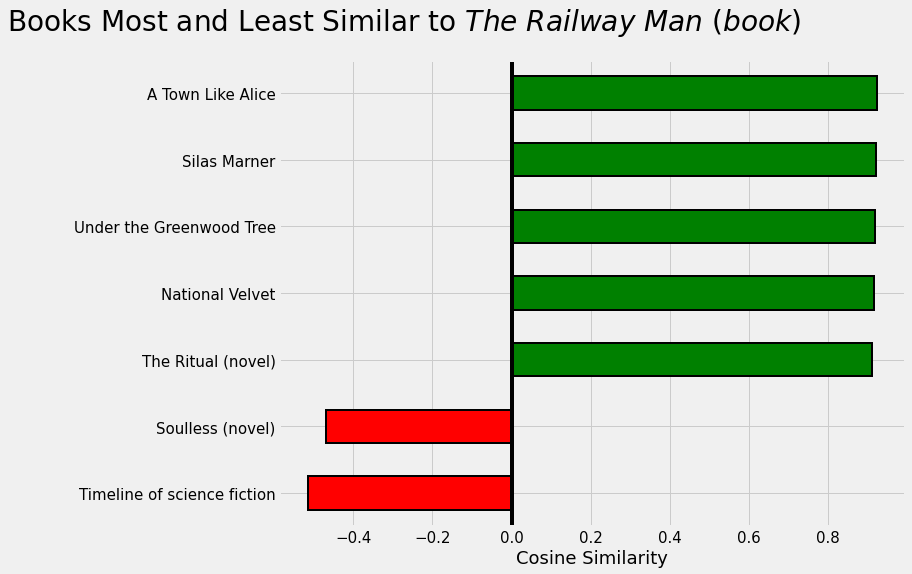

In [113]:
find_similar('The Railway Man (book)', book_weights, n = 5, plot = True)

[-69.05779  -16.744818]


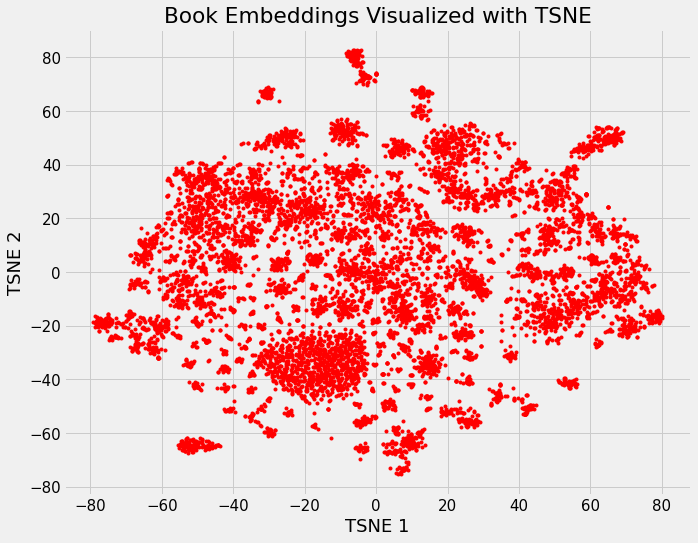

In [119]:
InteractiveShell.ast_node_interactivity = 'last'
from sklearn.manifold import TSNE
#from umap import UMAP
book_weights_class = extract_weights('book_embedding', model)
def reduce_dim(weights, components = 3):
    
    return TSNE(components, metric = 'cosine', square_distances = True).fit_transform(weights)
 
book_r = reduce_dim(book_weights_class, components = 2)
book_r.shape
print(book_r[0])


plt.figure(figsize = (10, 8))
plt.plot(book_r[:, 0], book_r[:, 1], 'r.')
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Book Embeddings Visualized with TSNE');